In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
from PIL import Image
from PIL import ImageOps
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import itertools
import operator
import cv2
import skimage.measure as measure
import string
import os
import math
from scipy import fftpack
from scipy import ndimage

In [4]:
def show_image(image, log = False, gray = False):
    if log:
        image = np.log(image)
    figure(dpi=100, figsize=(10,15))
    if gray:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)

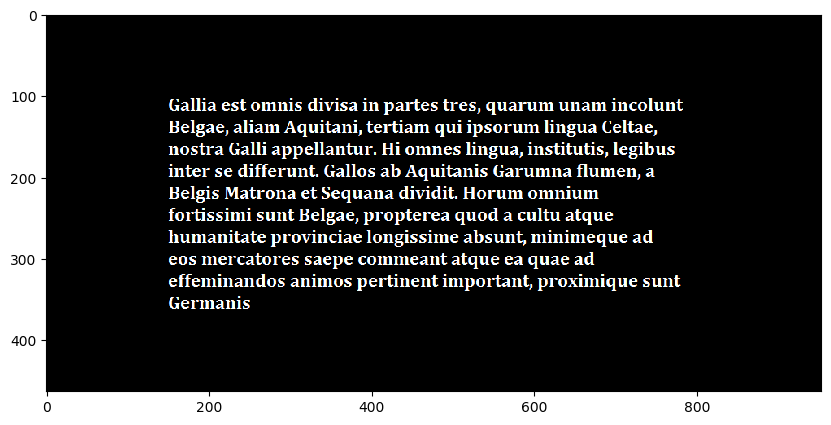

In [5]:
def fft(image_path, invert_color=True, text=True):
    
    image = Image.open(image_path)
    
    if invert_color:
        image = ImageOps.invert(image)
    figure(dpi=100, figsize=(10, 15))
    plt.imshow(image)
    
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude = np.absolute(fshift)
    phase = np.angle(fshift)
    return magnitude, phase

magnitude, phase = fft('galia.png')

In [6]:
def show_freq_mag(image_path, invert=True):
    image = Image.open(image_path)
    image = image.convert("L")
    if invert:
        image = ImageOps.invert(image)
    show_image(image, gray=True)
    image = np.array(image)
    freq = np.fft.fftshift(np.fft.fft2(image))
    magnitudes = np.absolute(freq)
    show_image(magnitudes, gray=True, log=True)
    phases = np.angle(freq)
    show_image(phases, gray=True)

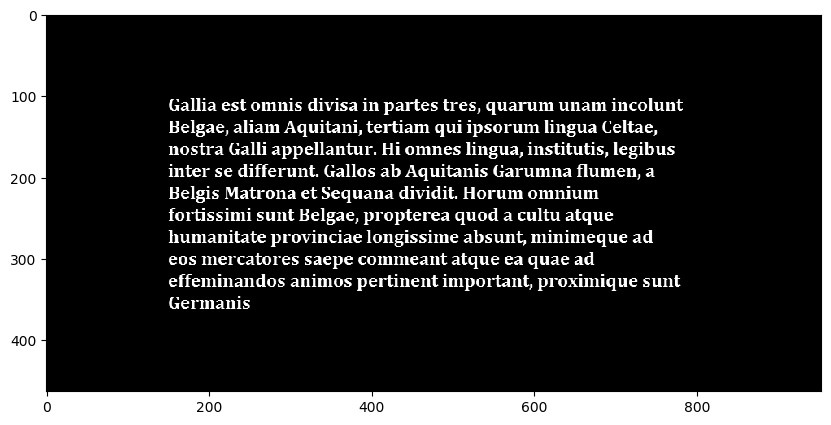

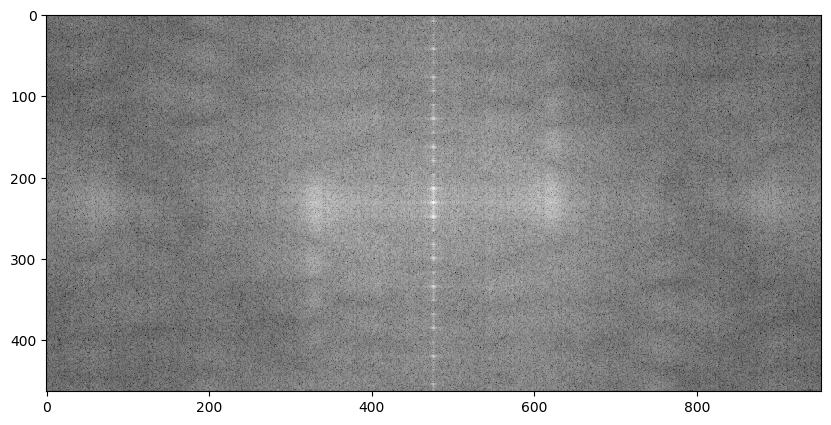

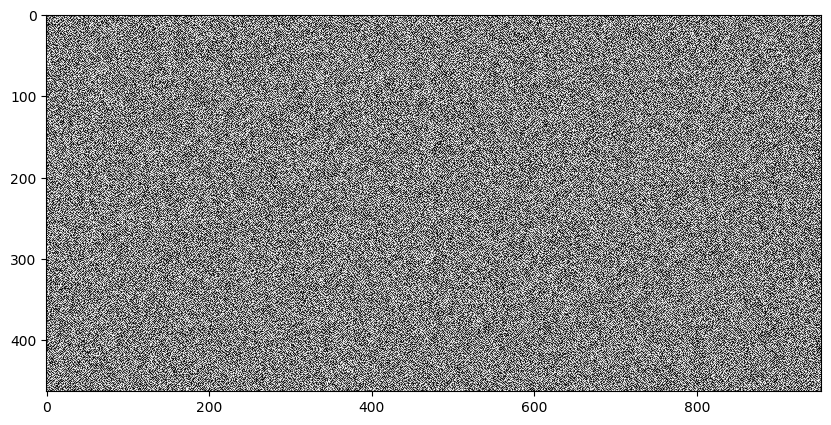

In [7]:
show_freq_mag("galia.png")

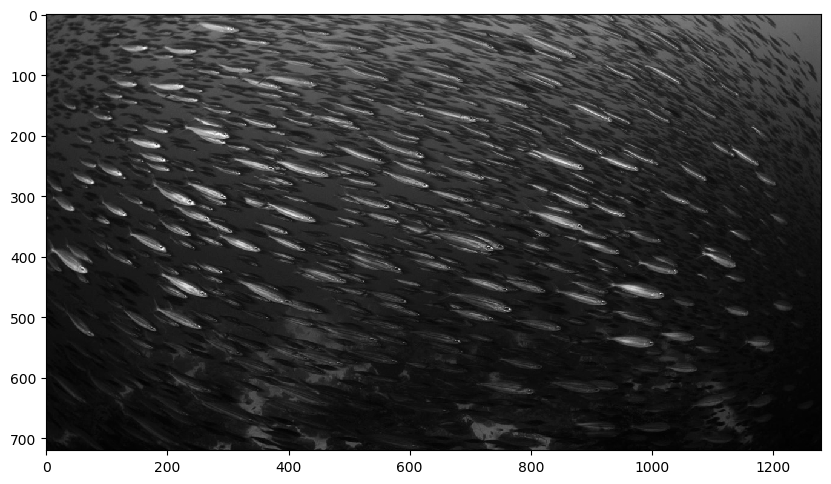

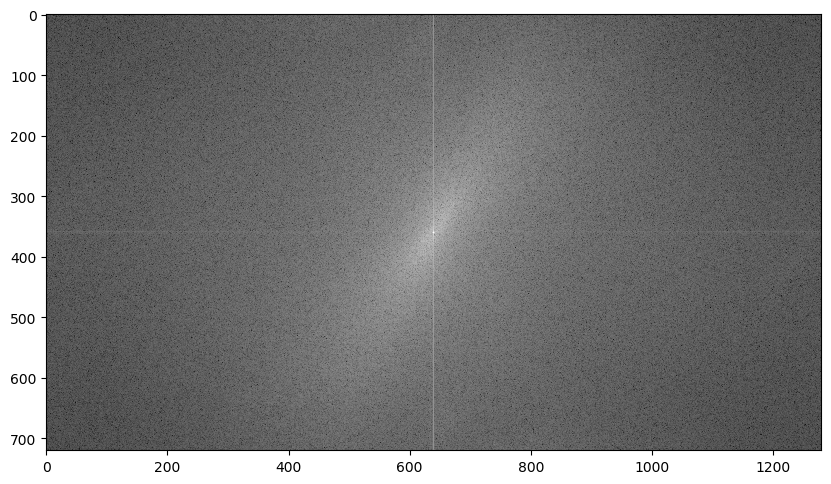

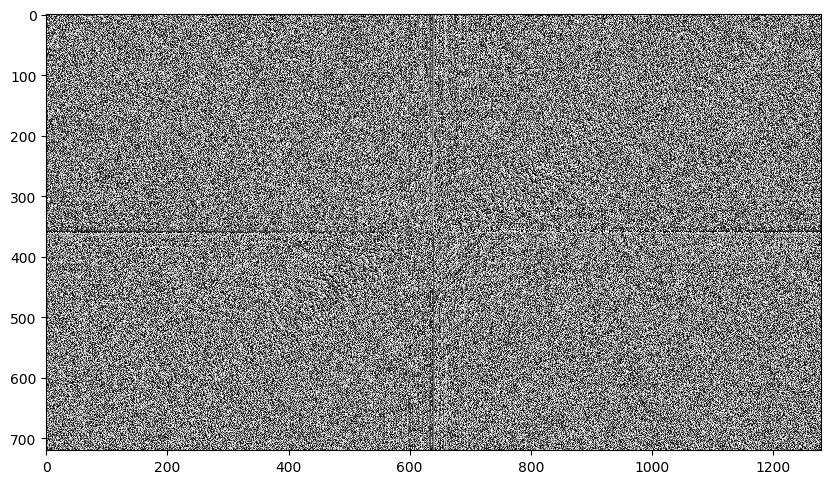

In [8]:
show_freq_mag("school.jpg", invert=False)

In [9]:
def get_image_array(image_path, invert):
    image = Image.open(image_path).convert("L")
    if invert:
        image = ImageOps.invert(image)
    return np.array(image)

In [10]:
def show_with_found(image, sample, correlation, is_text):
    dpi = 1
    fig, ax = plt.subplots(1)
    fig.set_dpi(200)
    ax.imshow(image, cmap='gray')
    c = correlation

    if is_text:
        boxes = []
        (w, h) = sample.shape
        for i in range(c.shape[0]):
            for j in range(c.shape[1]):
                if c[i, j]!=0: 
                    rect = Rectangle((j, i), -w, -h)
                    boxes.append(rect)
        pc = PatchCollection(boxes, facecolor='r', linewidth=1, edgecolor='r', alpha=0.2)
        ax.add_collection(pc)
    else:
        c = c.copy()
        c[c==0] = np.nan
        ax.imshow(c, cmap='Reds')
    plt.show()

In [11]:
def count_correlation(image_path, sample_path, corr_rate, invert, is_text):
    image = get_image_array(image_path, invert)
    sample = get_image_array(sample_path, invert)
    show_image(image, gray=True)
    
    rotated_sample = np.rot90(sample, 2)
    sample_fft = np.fft.fft2(rotated_sample, image.shape)
    image_fft = np.fft.fft2(image)
    correlation = np.fft.ifft2(np.multiply(sample_fft, image_fft))
    correlation = np.real(correlation)
    show_image(correlation, gray=True)
    min_corr = np.max(correlation) * corr_rate
    
    for i in range(correlation.shape[0]):
        for j in range(correlation.shape[1]):
            correlation[i, j] = 0 if correlation[i, j] <= min_corr else correlation[i, j]
    
    show_image(correlation, gray=True)
    show_with_found(image, sample, correlation, is_text)
    
    if is_text:
        return np.count_nonzero(correlation)
    else:
        return len(measure.find_contours(correlation, min_corr))

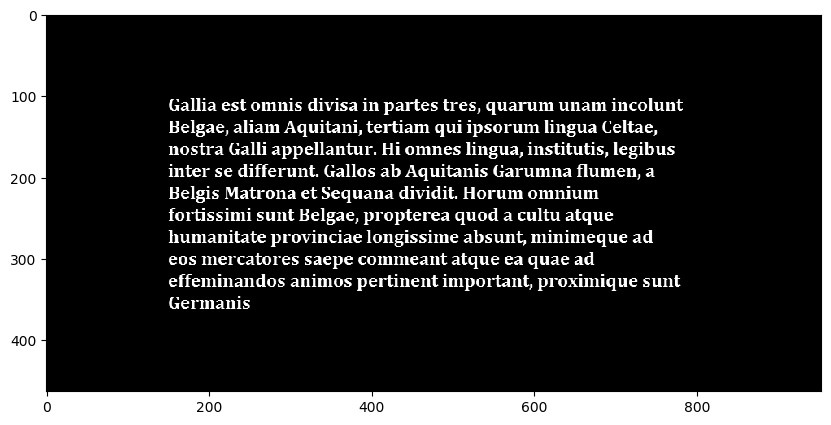

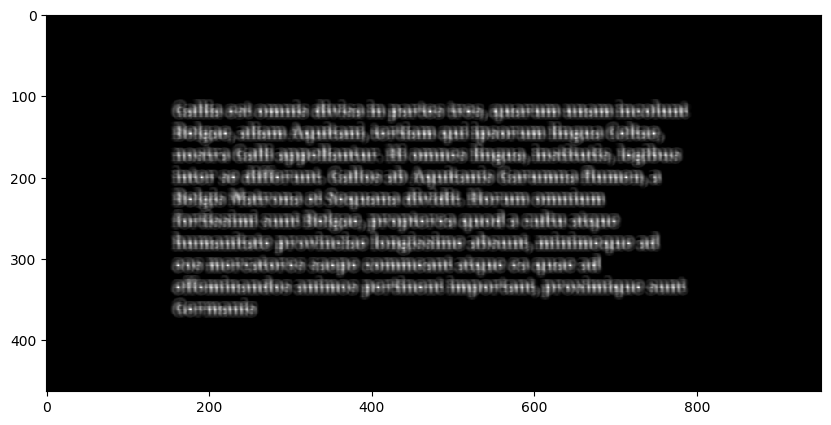

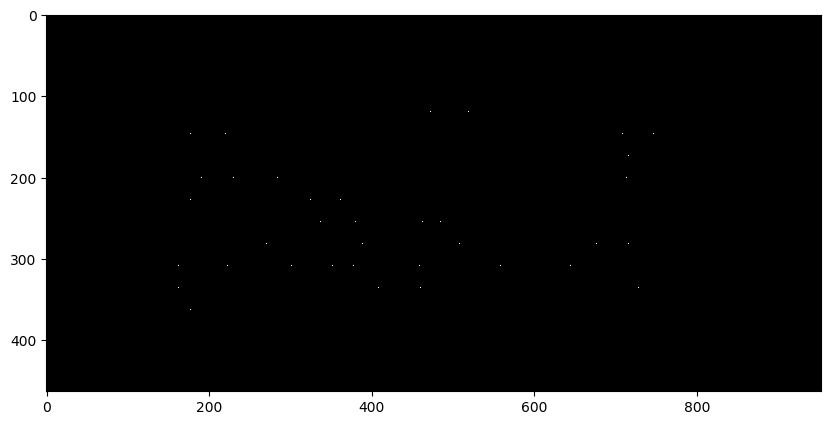

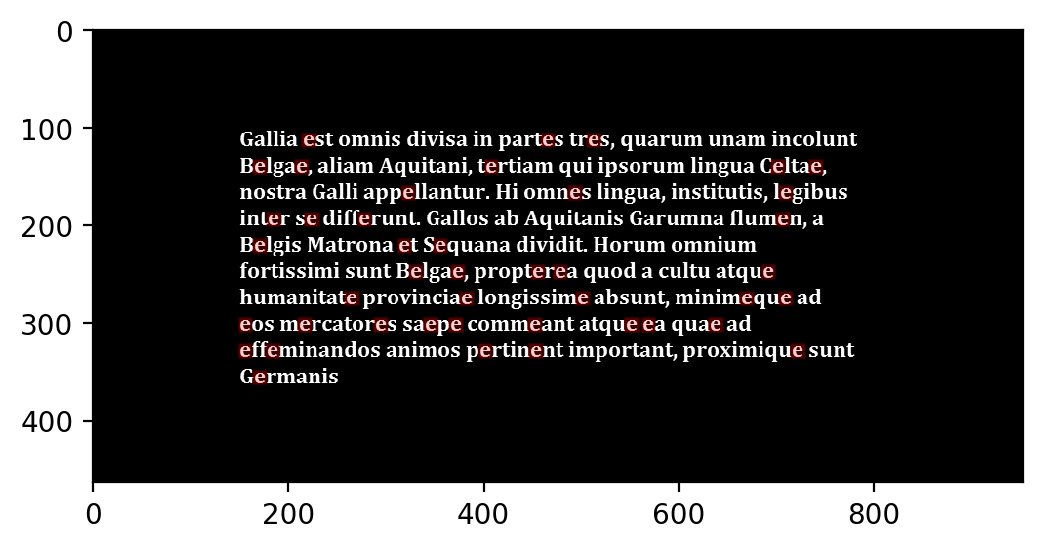

43


In [12]:
print(count_correlation("galia.png", "galia_e.png", 0.9, True, True))

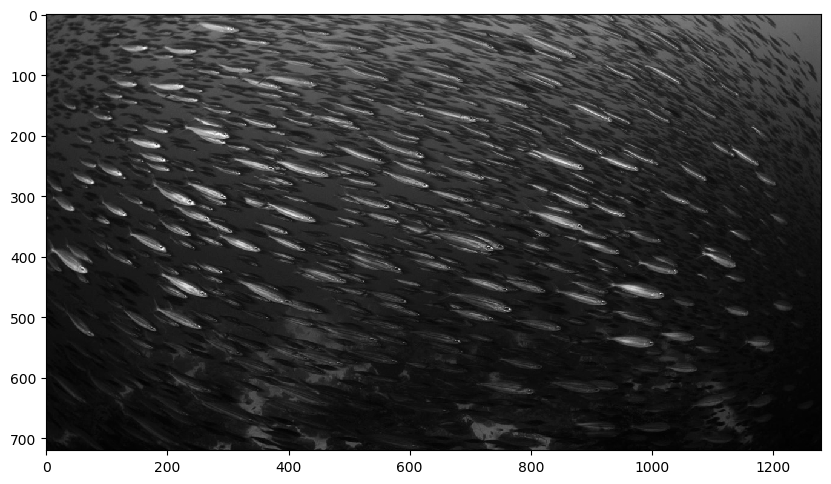

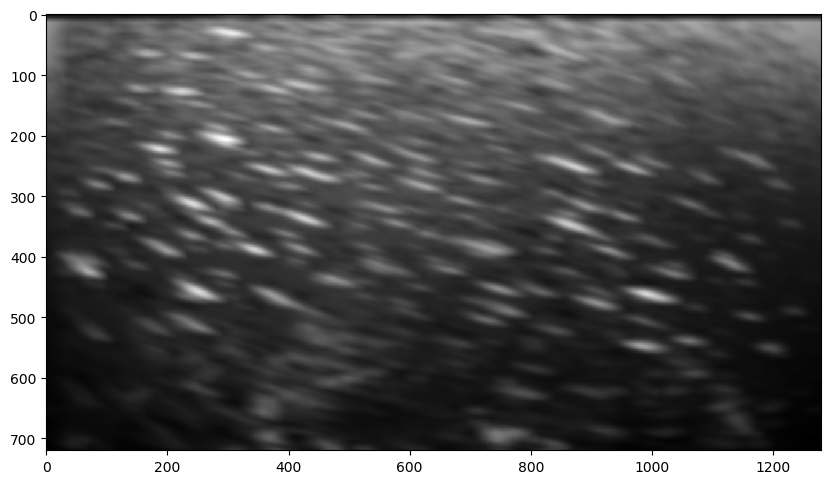

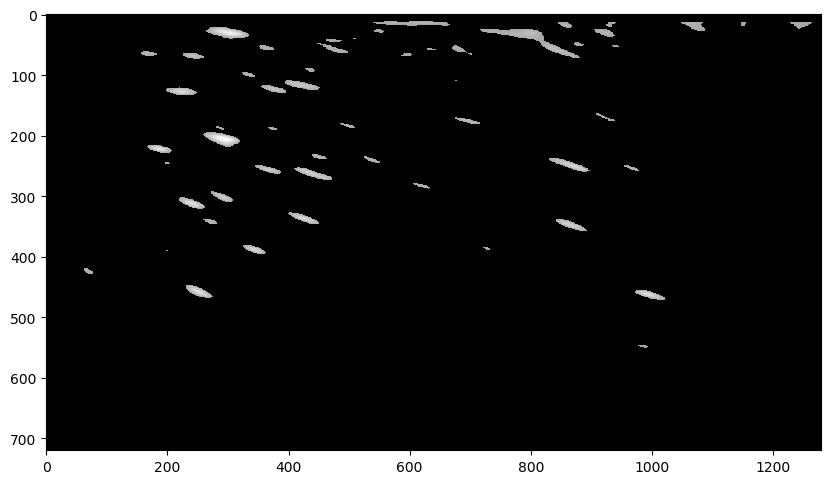

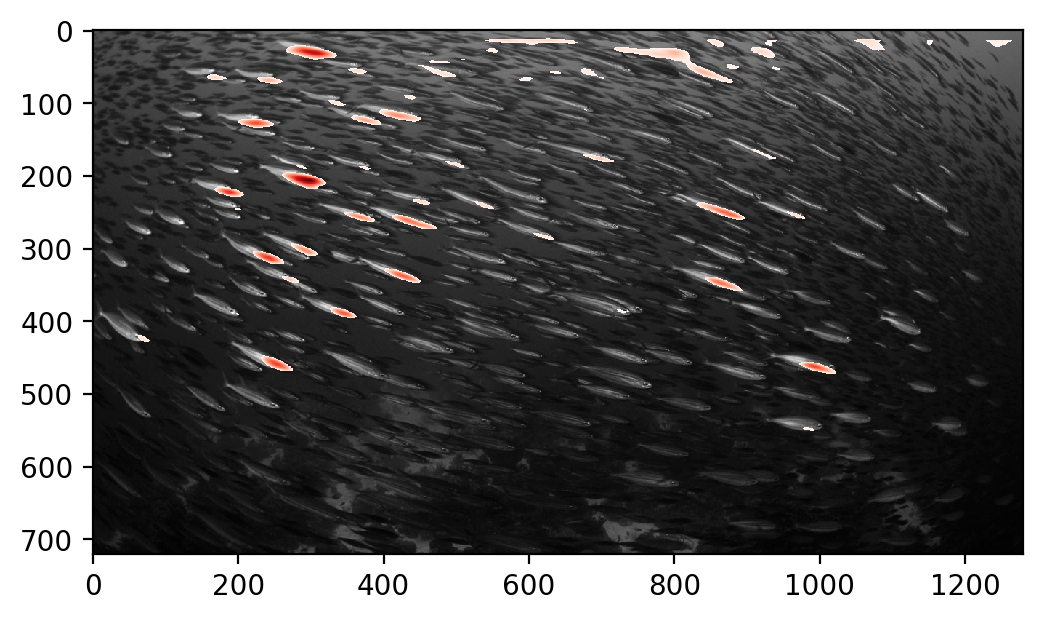

56


In [13]:
print(count_correlation("school.jpg", "fish1.png", 0.65, False, False))

In [14]:
def get_font(font_name):
    char_imgs = {}
    chars = list(string.ascii_lowercase + string.digits)
    
    char_imgs = {c:np.array(ImageOps.invert(Image.open(os.path.join(font_name, c+".png")).convert("L"))) for c in chars}
    chars = chars + ['.',',','?','!']
    for c in [("dot",'.'), ("comma",','), ("question-mark",'?'), ("exclamation-mark",'!')]:
        char_imgs[c[1]] = np.array(ImageOps.invert(Image.open(os.path.join(font_name, c[0]+".png")).convert("L")))
    return char_imgs

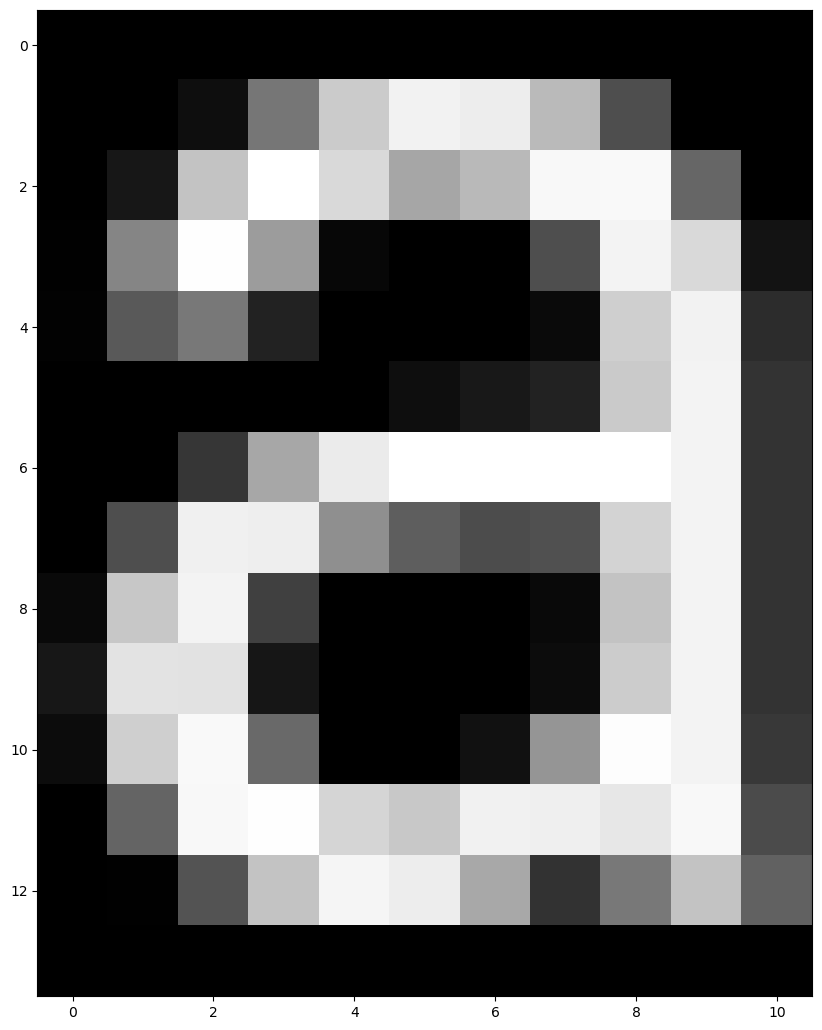

In [15]:
font = get_font('sans-serif')
show_image(font['a'], gray=True)

In [16]:
def rotate_and_inverse(image_path, reverse=True, show=False):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]    
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(gray, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    if show:
        show_image(image, gray=True)
        show_image(rotated, gray=True)
    return np.array(rotated).astype(float)

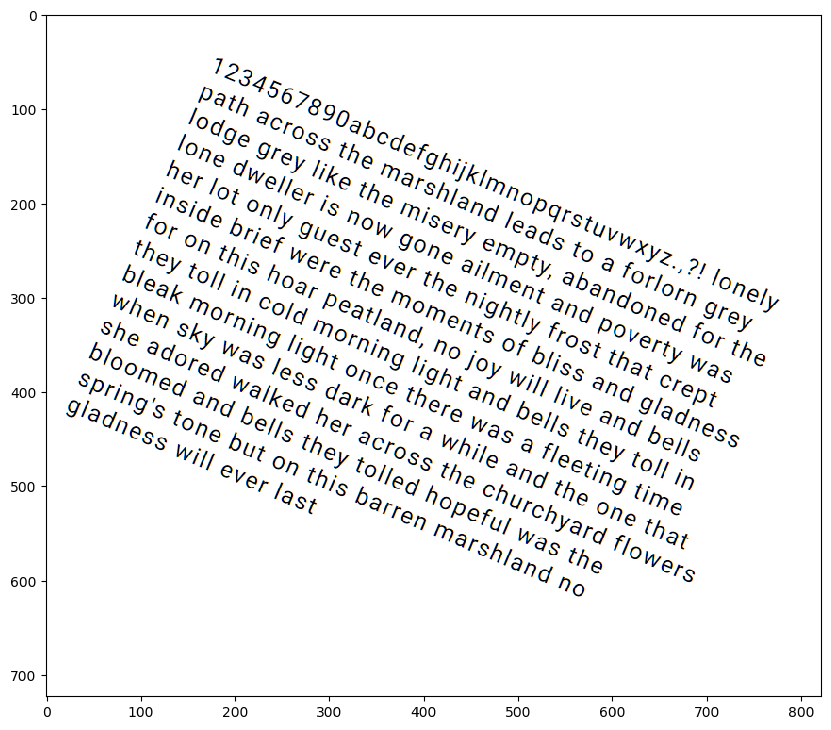

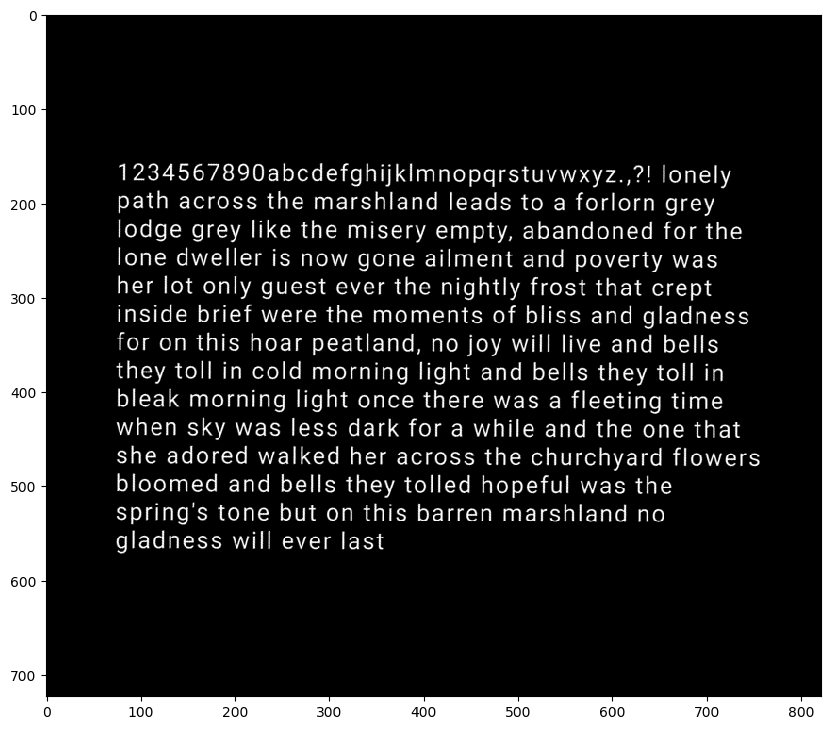

In [17]:
image = rotate_and_inverse('insomnium2.png', show=True)
image = np.array(image).astype(float)

In [18]:
def delete_noise(image, show=False):
    image = np.array(image).astype(float)
    im_fft = fftpack.fft2(image)
    keep_fraction = 0.4
    im_fft2 = im_fft.copy()
    r, c = im_fft2.shape
    im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
    im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0
    im_new = fftpack.ifft2(im_fft2).real
    if show:
        show_image(im_new, gray=True)
    return im_new

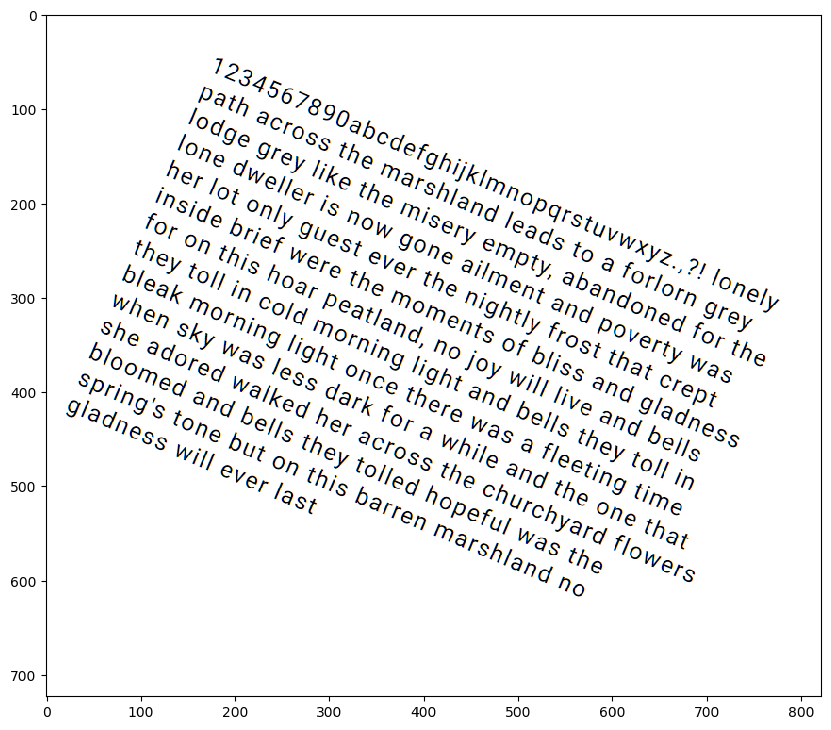

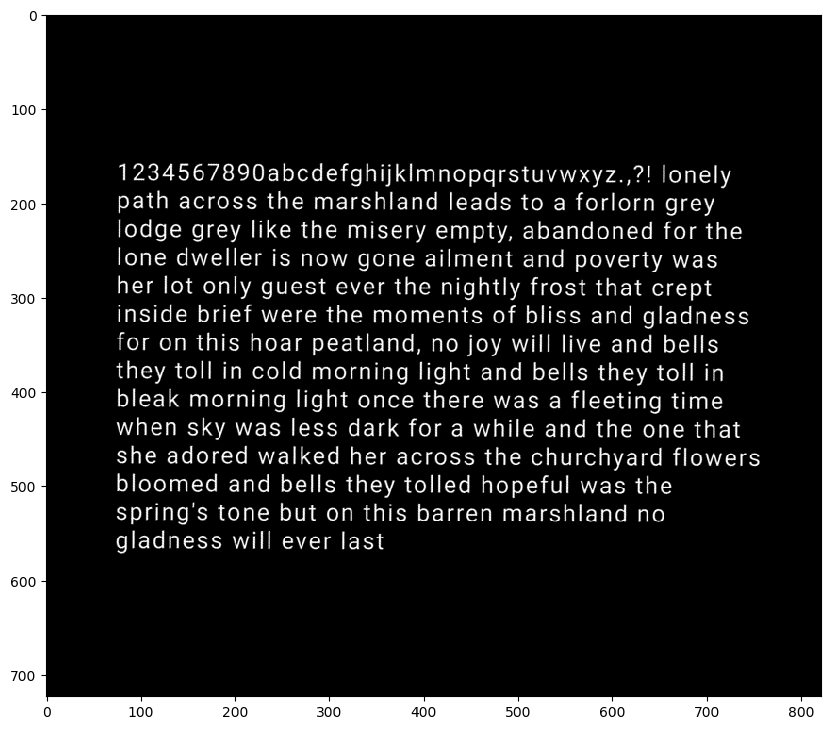

In [19]:
image = rotate_and_inverse("insomnium2.png", show=True)
image = delete_noise(image)

In [20]:
image = rotate_and_inverse("cellar2.png")
image = delete_noise(image)

In [21]:
def get_correlation_of(image, sample, corr_rate, show=False):
    rotated_sample = np.rot90(sample, 2)
    sample_fft = np.fft.fft2(rotated_sample, image.shape)
    image_fft = np.fft.fft2(image)
    correlation = np.fft.ifft2(np.multiply(sample_fft, image_fft))
    correlation = np.real(correlation)
    min_corr = np.max(correlation) * corr_rate
    filtered_corr = np.copy(correlation)
    filtered_corr[correlation <= np.max(correlation) * corr_rate] = 0
#     for i in range(correlation.shape[0]):
#         for j in range(correlation.shape[1]):
#             correlation[i, j] = 0 if correlation[i, j] <= min_corr else correlation[i, j]
    if show:
        show_image(correlation, gray=True)
    
    return filtered_corr

In [27]:
def identify_char(image, char_img, corr_rate = 0.9):
    correlation = get_correlation_of(image, char_img, corr_rate)
    letter_occurs = []
    h, w = char_img.shape
    n=0
    for i in range(correlation.shape[0]):
        for j in range(correlation.shape[1]):
            if correlation[i, j] != 0:
                n+=1
                up = i - h
                left = j - w
                letter_occurs.append((up, left))
                image[up : i + 1, left : j + 1] = 0 #deleting char from image
    show_image(image, gray=True)
#     print(n)
    return image, letter_occurs

In [23]:
def to_text(char_pos, new_line, space, font):
    res_str = ""
    all_char_pos = []
    for k, v in char_pos.items():
        for c in v:
            all_char_pos.append([c[0], c[1], k])
    all_char_pos.sort()
    lines = []
    n = 0
    prev = all_char_pos[0]
    prev_h = prev[0]
    lines.append([(prev[1], prev[2])])
    for i in range(1, len(all_char_pos)):
        curr = all_char_pos[i]
        curr_h = curr[0]
        if curr_h - prev_h >= new_line:
            lines.append([])
            n+=1
        else:   
            lines[n].append((prev[1], prev[2]))
        prev = curr
        prev_h = curr_h
        
    res_str=""
    first = True
    for l in lines:
        if not first:
            res_str += '\n'
        else:
            first = False
            
        prev_p, prev_c = l[0]
        prev_w = font[prev_c].shape[1]
        res_str += prev_c
        
        for i in range(1,len(l)):
            p, c = l[i]
            w = font[c].shape[1]
            if prev_w + prev_p - 2 <= p:
                if prev_p + prev_w + space <= p:
                    res_str+=" "
                res_str+=c
            prev_p, prev_c, prev_w = p, c, w
            
    return res_str    

c:\users\anian\anaconda3\envs\mownit_lab\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


{'a': 43, 'b': 30, 'd': 30, 'e': 57, 'f': 16, 'g': 15, 'p': 6, 'q': 2, '4': 3, 't': 34, 'w': 17, 'k': 4, 'x': 4, 'y': 20, 'v': 13, 'z': 4, 's': 60, '1': 1, '2': 7, '8': 58, '3': 7, '5': 75, '6': 30, '7': 2, '9': 9, '0': 10, 'u': 113, 'h': 28, 'j': 6, 'l': 6, 'm': 29, 'n': 10, 'o': 6, 'c': 7, 'r': 4, 'i': 72, '!': 21, '?': 3, ',': 6, '.': 3}


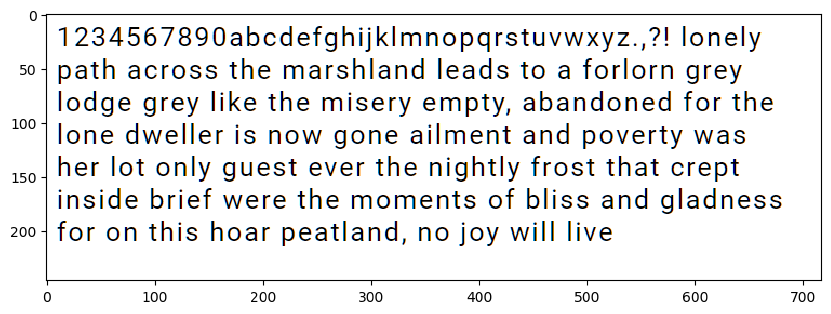

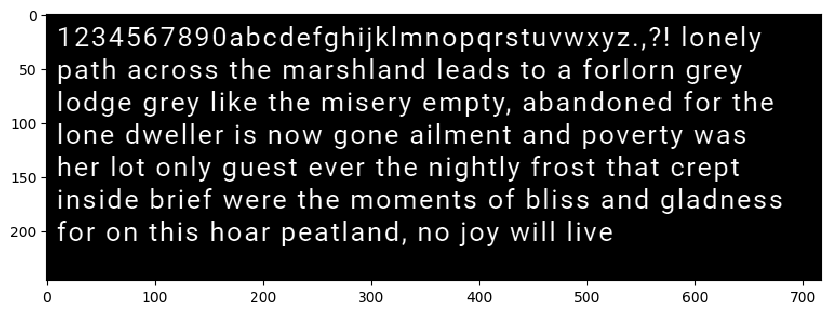

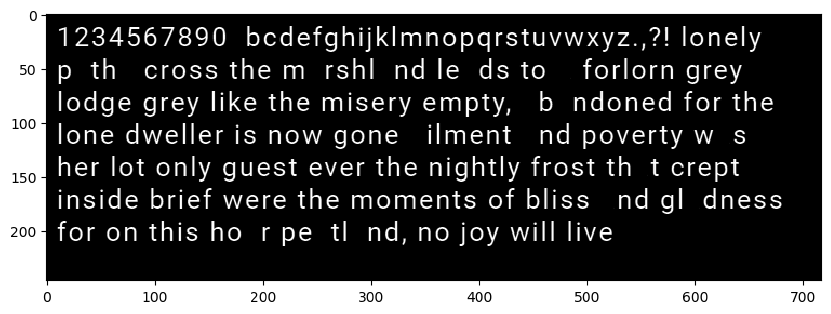

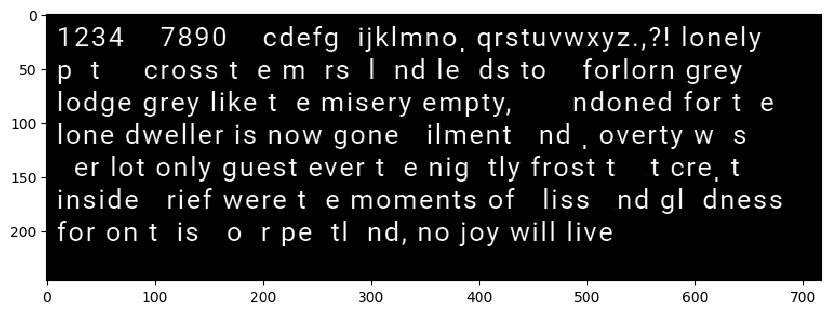

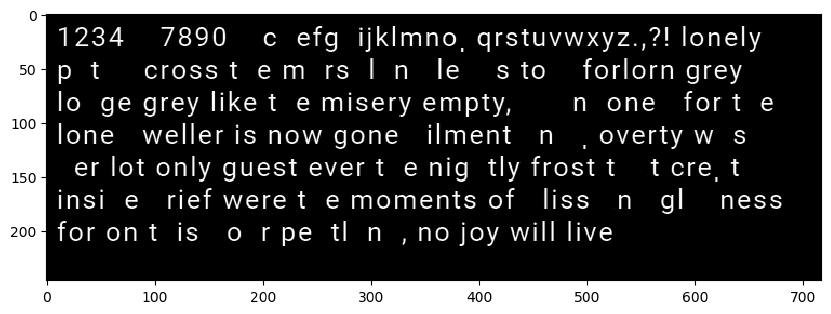

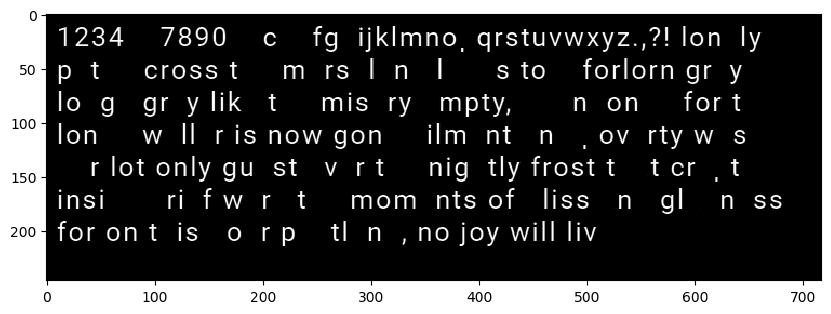

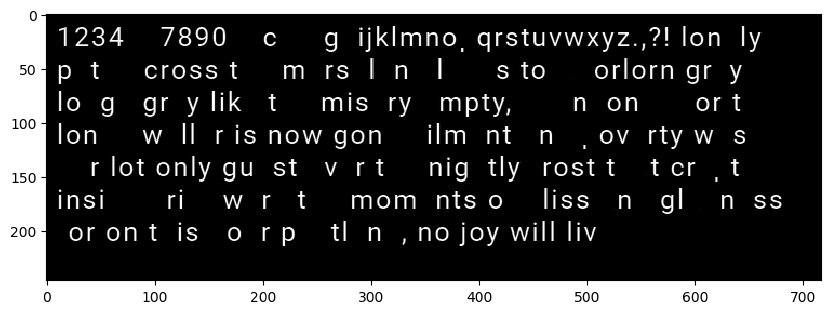

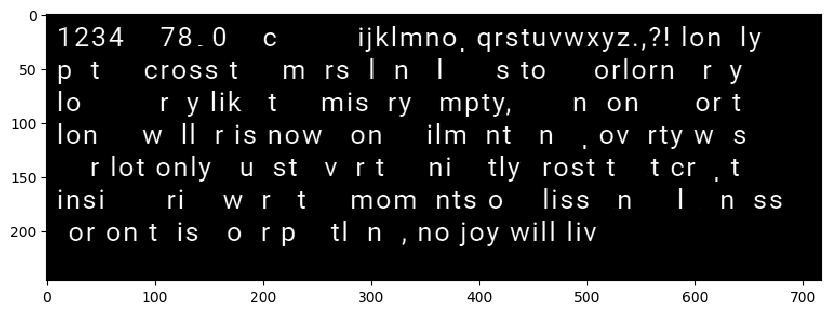

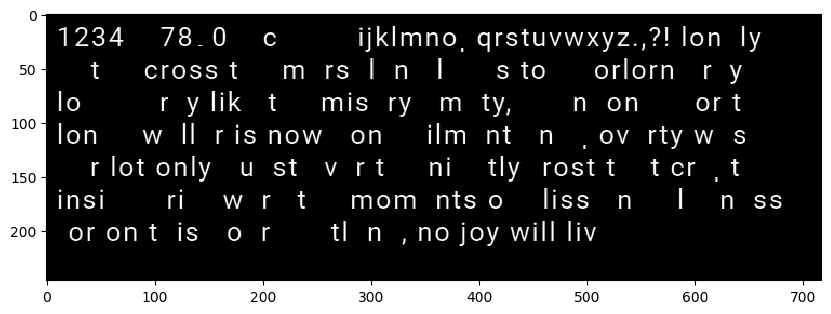

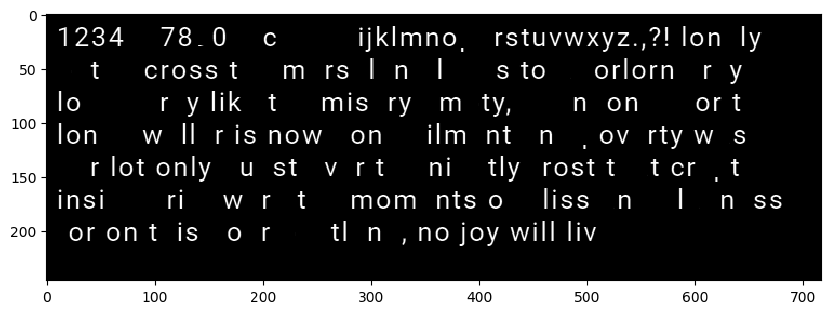

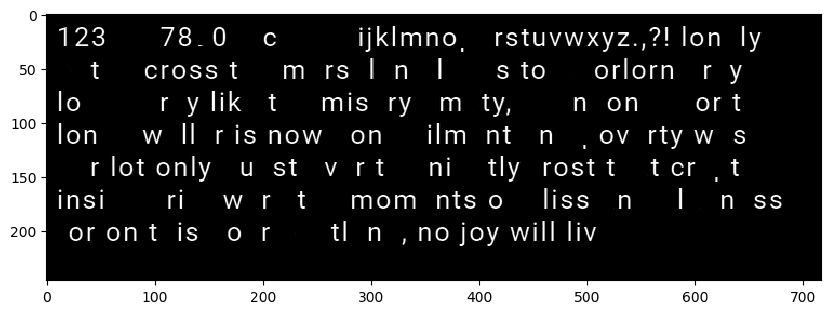

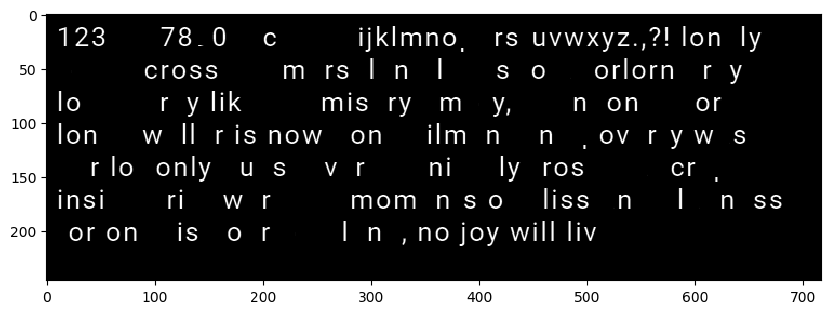

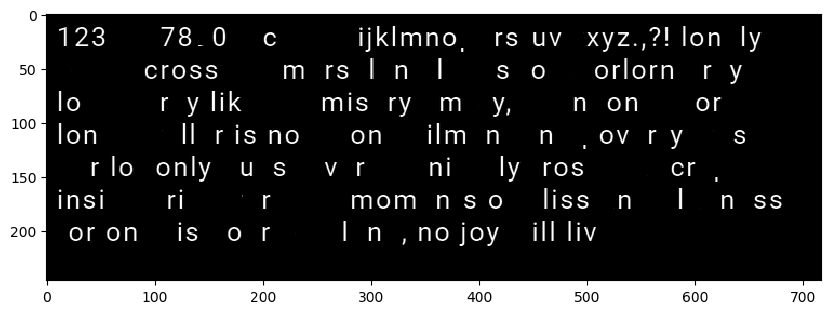

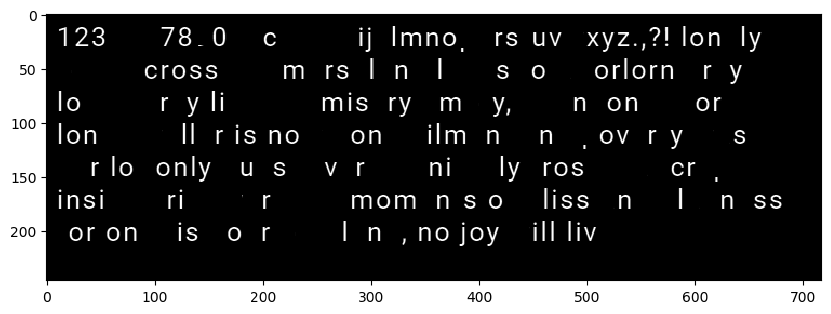

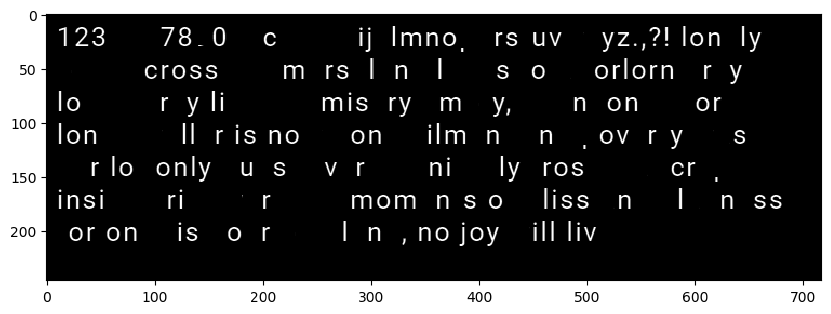

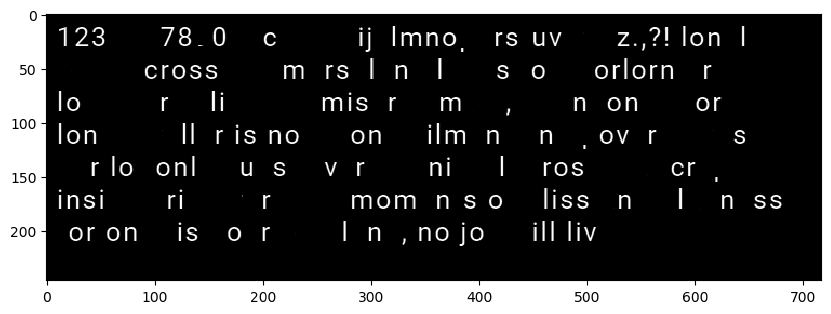

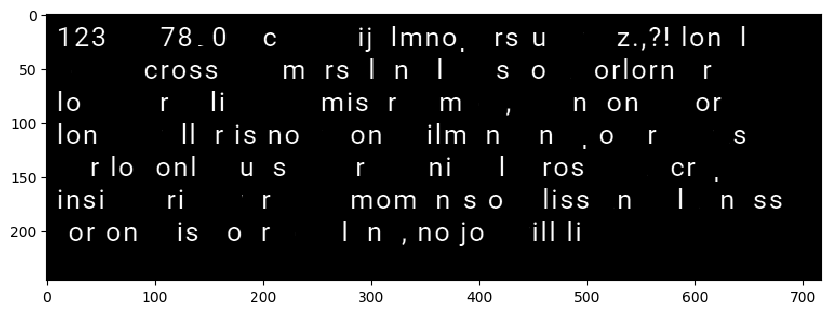

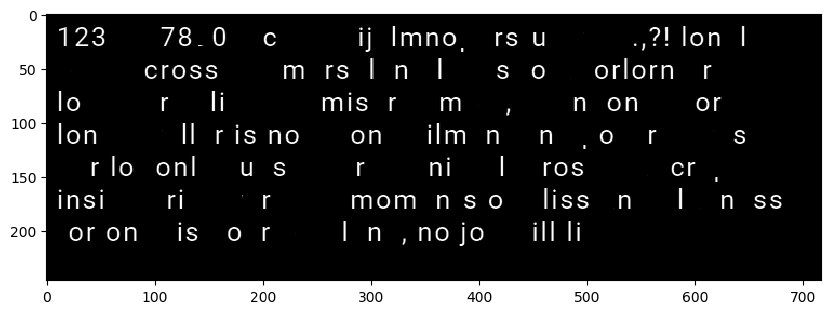

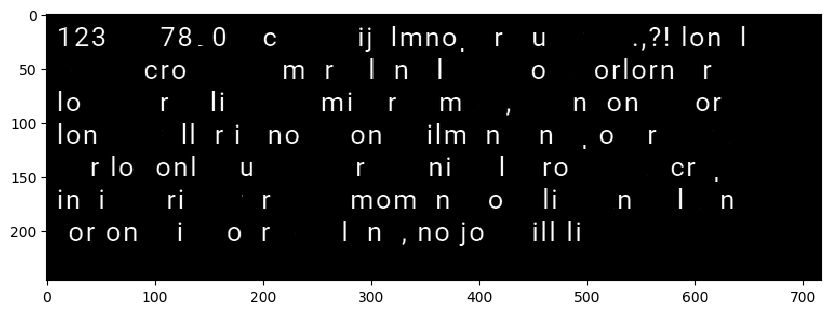

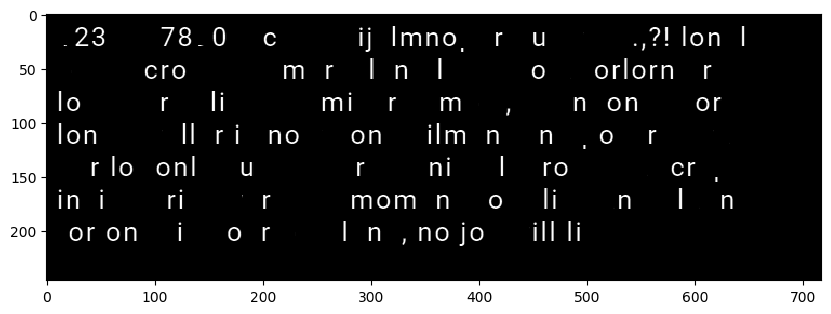

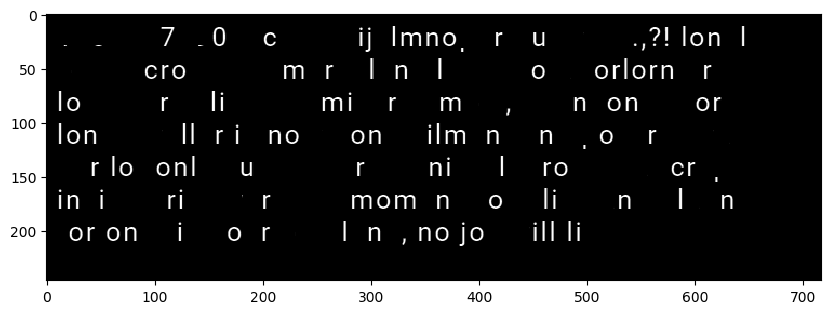

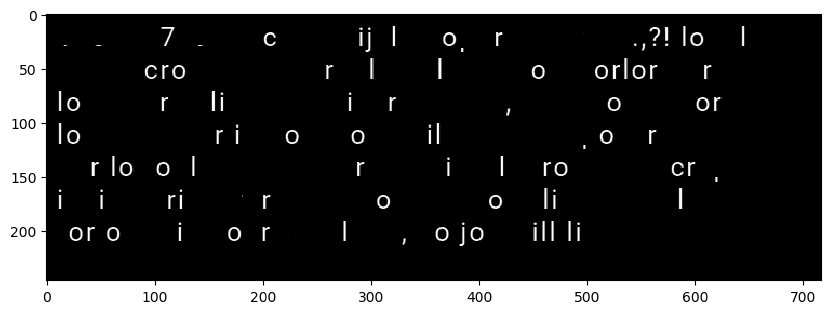

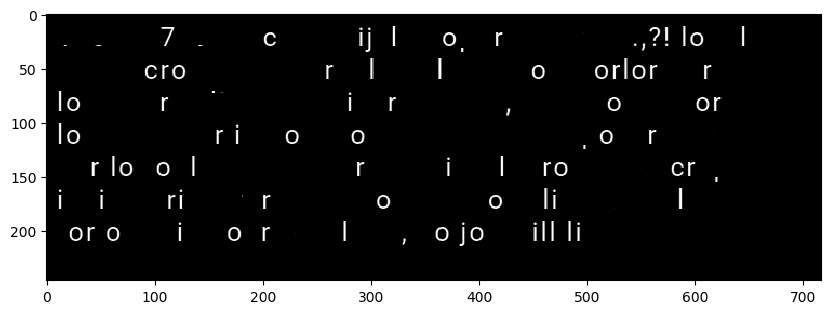

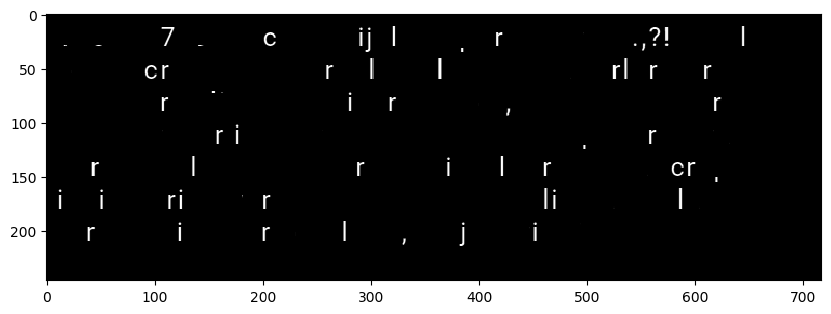

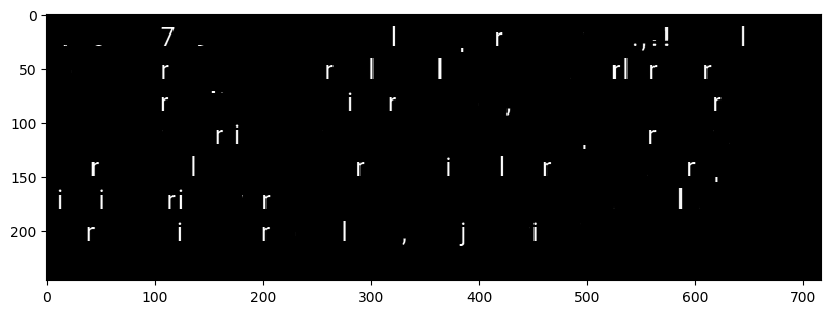

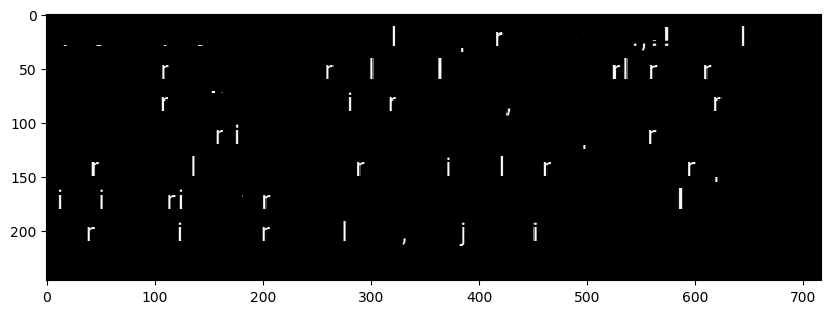

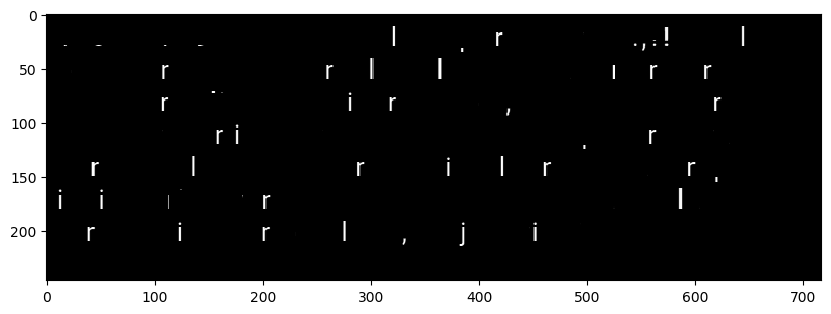

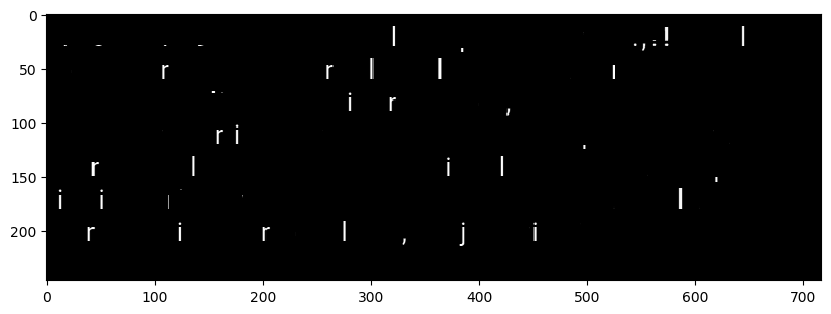

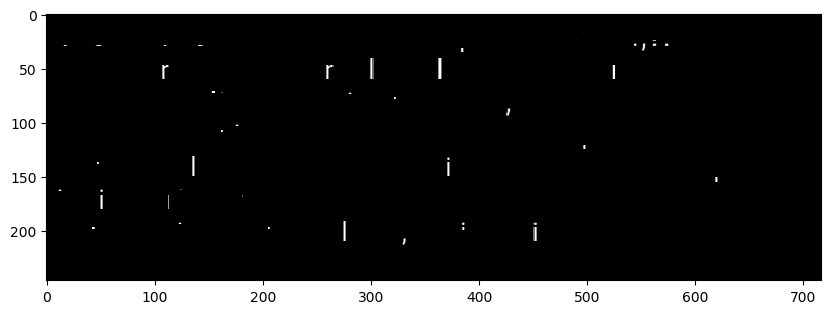

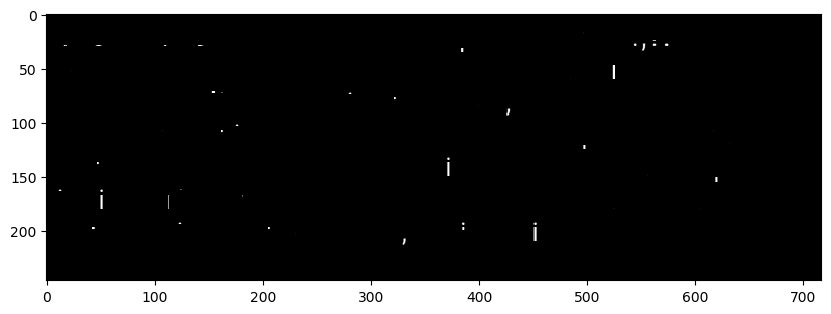

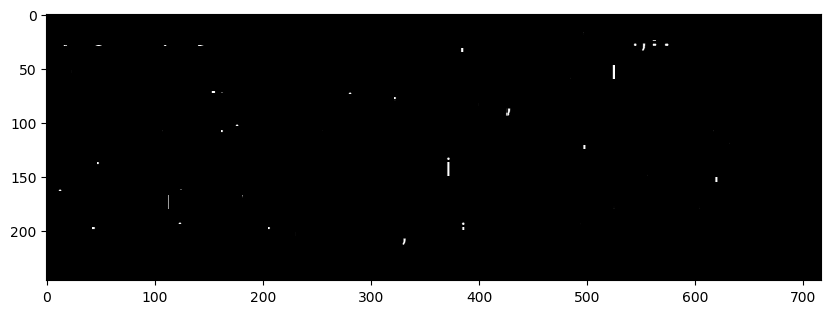

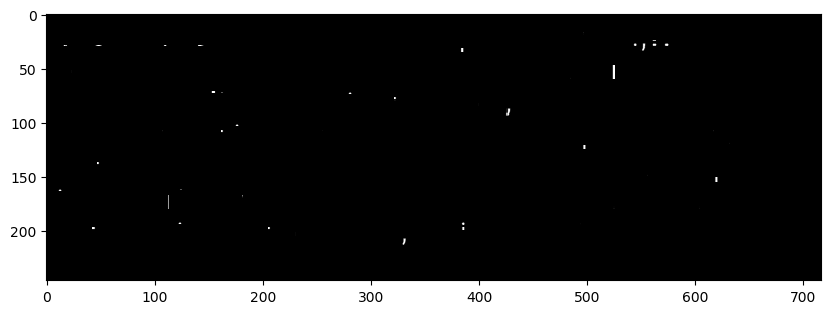

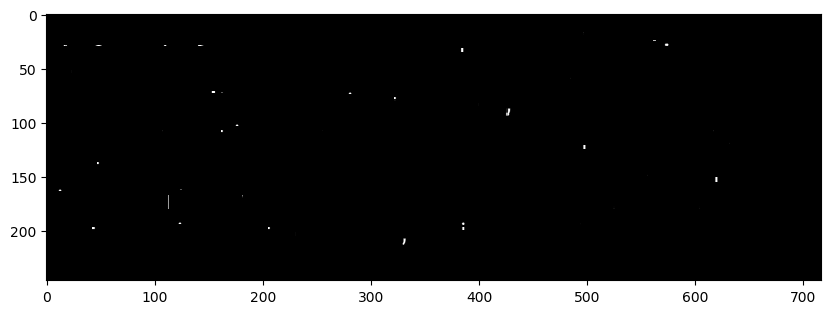

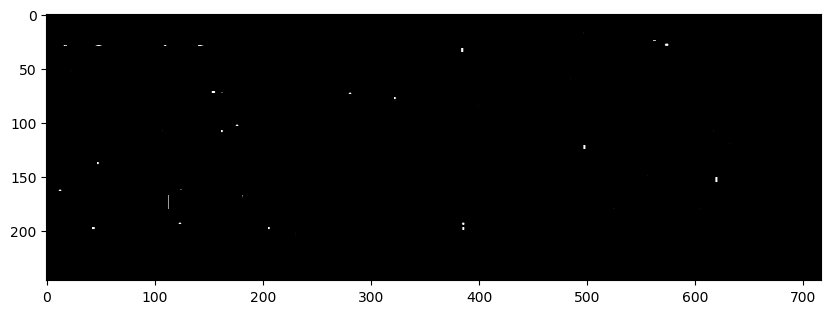

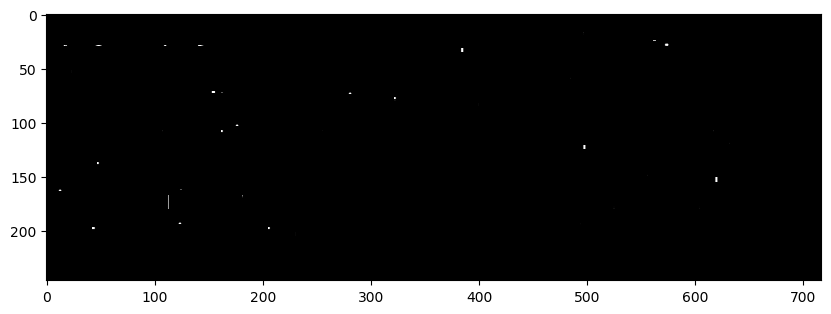

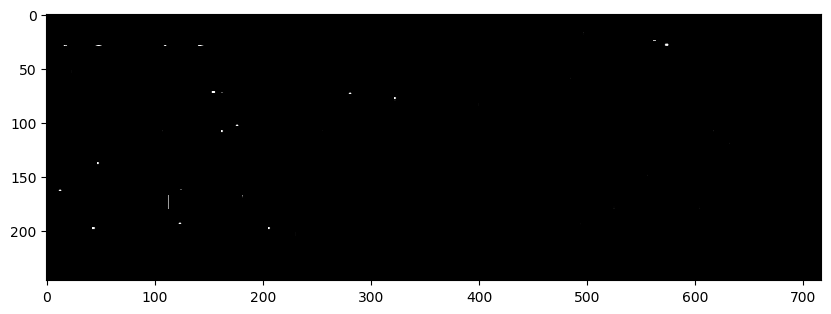

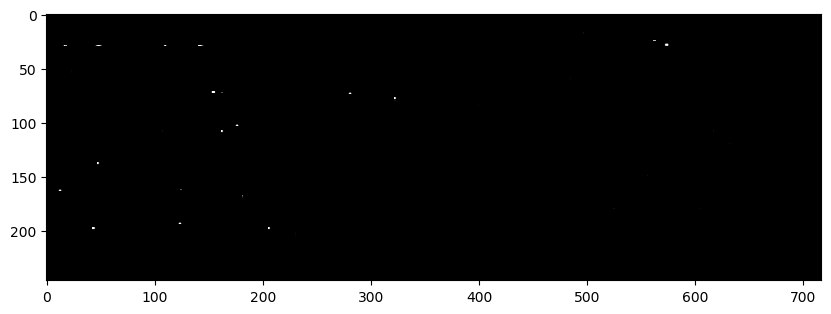

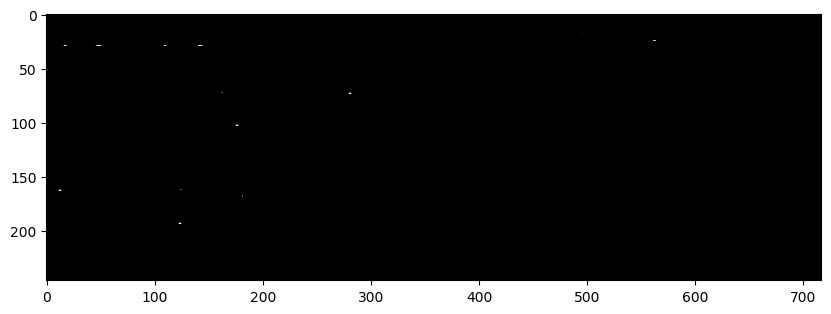

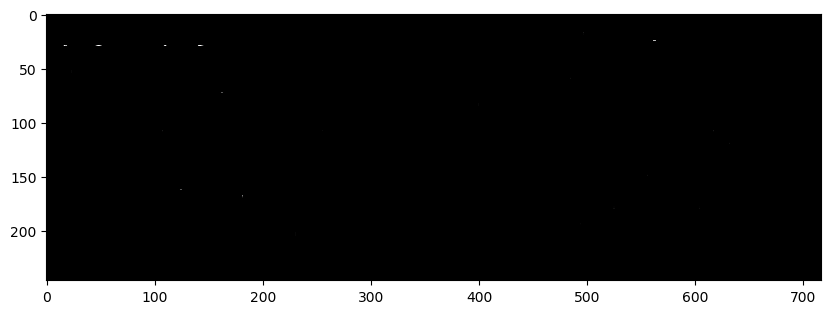

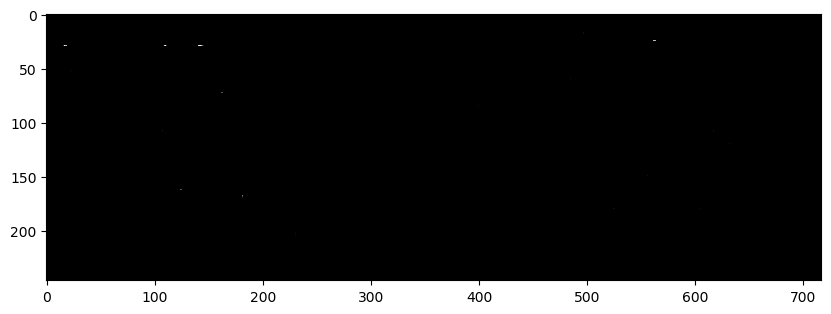

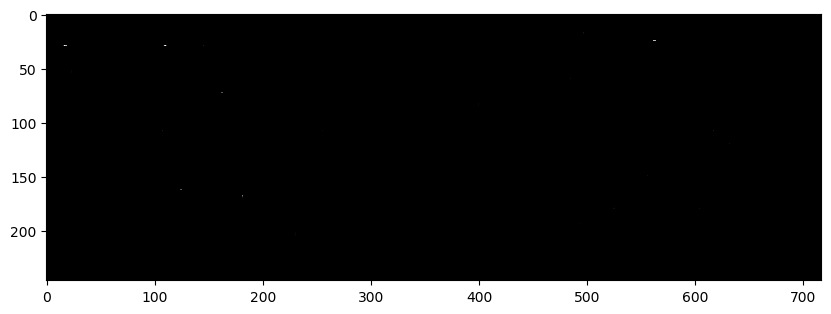

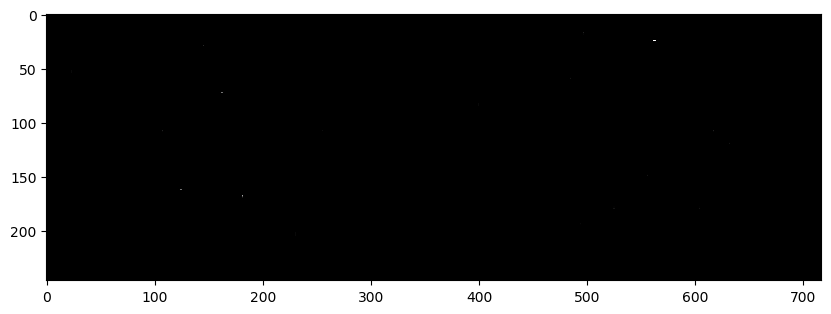

In [28]:
char_pos = {}
char_stats = {}
font = get_font('sans-serif')
chars_order = ["a", "b", "d", "e", "f", "g", "p", "q", "4", "t", "w", "k", "x", "y", 
                           "v", "z", "s", "1", "2", "8", "3", "5", "6", "7", "9", "0", "u", "h", 
                           "j", "l", "m", "n", "o", "c", "r", "i", "!", "?", ",", "."]
rates = {"r": 0.87, "u": 0.89, "1": 0.95, "5": 0.95, "j": 0.96, "l": 0.9, "i": 0.85, "0": 0.97, "v": 0.85, "!": 0.95, ".": 0.95, "3": 0.95, "9": 0.95}
image = rotate_and_inverse('insomnium4.png', show=True)
for char in chars_order:
#     print(char)
    if char in rates:
        image, letter_occurs = identify_char(image, font[char], rates[char])
    else:
        image, letter_occurs = identify_char(image, font[char])
    char_pos[char] = letter_occurs
    char_stats[char] = len(letter_occurs)
print(char_stats)

In [25]:
print(char_pos['a'])

[(166, 18), (167, 18), (23, 48), (24, 48), (72, 48), (73, 48), (239, 48), (240, 48), (303, 48), (304, 48), (381, 48), (382, 48), (470, 48), (23, 49), (72, 49), (239, 49), (382, 49), (470, 49), (437, 78), (438, 78), (468, 78), (469, 78), (469, 79), (333, 108), (334, 108), (437, 108), (438, 108), (617, 108), (617, 109), (541, 138), (541, 139), (510, 168), (589, 168), (510, 169), (589, 169), (180, 198), (181, 198), (245, 198), (246, 198), (278, 198), (279, 198), (245, 199), (279, 199)]


In [26]:
to_text(char_pos, 9, 5, font)

'j , , , , , i i i i l l l i . , . b r n , , r n , e e , , , r i s r n s r . ,, l e u e , o d ! l c u , , , j r i , l n i e o l .tr , g l i t . . , j , , r i , b r n i i n , . , s e s e , . i f j , . . e , r , b i n j , q , q lt , . i u o x w , b , n u s s a u , . e i e , rt , , r , i n i s e e h , b p i n l .t c . o i m .t r e e b , w e n e , a e r , , i r n l .t v . r e e r g n q c s i o , e e , a s n r s m , , . r r n t n , e , , i a j , , , , d l e u n , r y n y , . v m e e ! l a u , r n e , e i l r r n , , , , n t . , m , r g n l , c , u , i a p l s . s s , b e e m n t , d . , , u t . y y v i , l v i , l .t i . , f . r , , v v tt . l , w , v a e f b u . u , o , , r r n , , j d c s u , o s , r , s s l n , f . s , i s t u o r v d u , , , lt e a e e , , r , h r v n n , j i l . a u l r .t r . , r .t . j d ,, r q q , l u i v , , , c a e , v , e e d ! l c r , b u o r , ,, i nt y t . y . r , v i s , e n , s s'